In [2]:
import json
import http.client
from urllib.parse import urlencode, quote_plus, quote
import pandas as pd
from datetime import datetime
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from ydata_profiling.visualisation.plot import timeseries_heatmap
from ydata_profiling import ProfileReport

/media/clem/data/Documents/src/sandbox/webstat-tsclustering/.venv/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)
/media/clem/data/Documents/src/sandbox/webstat-tsclustering/.venv/lib/python3.8/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/media/clem/data/Documents/src/sandbox/webstat-tsclustering/.venv/lib/python3.8/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will

# Import final dataframe

In [10]:
final_df = pd.read_csv("final_df.csv", index_col=0)
final_df.index = pd.to_datetime(final_df.index)

In [11]:
final_df.describe()

,"Encours d'actions cotées, Valeur de marché (SEC 95)","Remboursements d'actions cotées (flux monétaire), Valeur de marché (SEC 95), Flux cumulés 12 mois glissants","Emissions brutes d'actions cotées (yc apport en nature), Valeur de marché (SEC 95), Flux cumulés 12 mois glissants","Emissions nettes d'actions cotées (yc opérations d'apport en nature), Valeur de marché (SEC 95), CVS","Emissions nettes d'actions cotées (yc opérations d'apport en nature), Valeur de marché (SEC 95), Flux cumulés 12 mois glissants","Emissions nettes (flux monétaire) de titres de dette, Hors opérations internes aux groupes bancaires, Hors produits financiers dérivés, Valeur nominale, CVS","Emissions nettes de titres de dette, Cumul annuel","Encours de titres de dette, Hors produits financiers dérivés, Hors opérations internes aux groupes bancaires, Valeur nominale","Emissions nettes (flux monétaire) de titres de dette, Sociétés non financières, Hors produits financiers dérivés, Valeur nominale, CVS","Emissions nettes de titres de dette des sociétés non financières, Cumul annuel",...,"Bilans d'Entreprises, Productivité du capital d'exploitation (rendement apparent), Activités immobilières, Toutes tailles, Critères LME, Ratio moyen, Brut","Bilans d'Entreprises, Coût apparent de l'endettement, Tous secteurs, Entreprises de taille Intermédiaire, Critères LME, Ratio moyen, Brut","Bilans d'Entreprises, Taux d'endettement financier (sur VA), Soutien aux entreprises, Toutes tailles, Critères LME, Ratio moyen, Brut","Bilans d?Entreprises, Stocks, France, Enseignement, santé humaine et action sociale, Toutes tailles, Critères LME, Ratio moyen, Annuelle,Brut.",Taux du Livret A,Taux effectif moyen au cours des trois mois précédents des prêts relais accordés aux particuliers,Seuil de l'usure des prêts relais aux particuliers,Taux effectif moyen au cours des trois mois précédents des prêts immobiliers à taux variables accordés aux particuliers,Seuil de l'usure des prêts immobiliers à taux variable aux particuliers,Taux du livret de développement durable et solidaire
count,2.400000e+02,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,2.400000e+02,240.000000,240.000000,...,20.000000,20.000000,20.000000,20.000000,240.000000,80.000000,80.000000,80.000000,80.000000,240.000000
mean,1.463898e+06,10334.300000,26220.816667,1304.458333,15886.483333,11022.845833,131734.565967,2.713524e+06,2050.270833,24450.895950,...,8.550000,4.570000,57.690000,10.135000,1.950000,4.526875,6.103750,4.133500,5.577125,1.950000
std,3.828594e+05,7486.250138,12256.865208,2635.378664,11627.875692,12224.408553,65166.362384,8.285970e+05,3744.690944,19351.452543,...,0.850077,1.189029,9.348678,1.723605,0.914836,1.366893,1.805509,1.430329,1.887793,0.914836
min,7.555040e+05,1608.000000,6637.000000,-8846.000000,-4232.000000,-22124.000000,-21098.099000,1.277716e+06,-8941.000000,-12875.512000,...,7.300000,2.800000,42.500000,7.200000,0.750000,2.190000,2.990000,1.770000,2.410000,0.750000
25%,1.178094e+06,4539.500000,16176.250000,137.500000,8588.000000,4016.000000,102042.552250,1.913270e+06,-491.500000,10636.657750,...,7.700000,3.625000,48.675000,8.550000,1.000000,3.655000,5.122500,3.100000,4.375000,1.000000
50%,1.409364e+06,9546.000000,25690.000000,777.500000,12825.500000,10563.000000,129401.170000,2.852173e+06,1615.000000,25780.827000,...,8.650000,4.600000,60.000000,10.450000,2.250000,4.600000,6.205000,4.220000,5.665000,2.250000
75%,1.735972e+06,12948.750000,34555.750000,1858.000000,22652.000000,18109.500000,170699.775000,3.455851e+06,3674.750000,38189.729750,...,9.125000,5.475000,65.750000,11.400000,2.750000,5.310000,7.150000,5.195000,7.032500,2.750000
max,2.355010e+06,34753.000000,57801.000000,18295.000000,48266.000000,45565.000000,304410.281000,3.988941e+06,19679.000000,70863.000000,...,9.900000,6.600000,70.600000,12.800000,4.000000,7.420000,9.890000,6.950000,9.270000,4.000000


# Apply transformations to dataset

* remove null values
* check sequenced datetime index
* normalize time serie values

In [25]:
final_df.iloc[:,(final_df.isnull().sum() > 200).tolist()].shape

(240, 911)

In [15]:
final_df.isna().any()

final_df.columns[final_df.isna().any()].tolist()

['Estonie, Taux de chômage (CVS)',
 'Taux de chômage au sens du BIT - Ensemble - France hors Mayotte - Données CVS',
 'Finlande, indice du prix à la production industrielle [hors construction]',
 'Défaillances, Agriculture, sylviculture et pêche, Grand Est, Unités légales, nombre cumulé sur le trimestre',
 'Défaillances, Industrie, Grand Est, Unités légales, nombre cumulé sur le trimestre',
 'Défaillances, Construction, Grand Est, Unités légales, nombre cumulé sur le trimestre',
 'Défaillances, Commerce et réparation automobile, Grand Est, Unités légales, nombre cumulé sur le trimestre',
 'Défaillances, Transports et entreposage, Grand Est, Unités légales, nombre cumulé sur le trimestre',
 'Défaillances, Hébergement et restauration, Grand Est, Unités légales, nombre cumulé sur le trimestre',
 'Défaillances, Information et communication, Grand Est, Unités légales, nombre cumulé sur le trimestre',
 "Défaillances, Activités financières et d'assurance, Grand Est, Unités légales, nombre cum

In [12]:
final_df.isnull().any()

Encours d'actions cotées, Valeur de marché (SEC 95)                                                                                False
Remboursements d'actions cotées (flux monétaire), Valeur de marché (SEC 95), Flux cumulés 12 mois glissants                        False
Emissions brutes d'actions cotées (yc apport en nature), Valeur de marché (SEC 95), Flux cumulés 12 mois glissants                 False
Emissions nettes d'actions cotées (yc opérations d'apport en nature), Valeur de marché (SEC 95), CVS                               False
Emissions nettes d'actions cotées (yc opérations d'apport en nature), Valeur de marché (SEC 95), Flux cumulés 12 mois glissants    False
                                                                                                                                   ...  
Taux effectif moyen au cours des trois mois précédents des prêts relais accordés aux particuliers                                   True
Seuil de l'usure des prêts relais aux par

In [25]:
# TODO problem avec NA
print(final_df.dropna(axis=0).shape)
print(final_df.dropna(axis=1).shape)
print(final_df.shape)

final_df_wona = final_df.dropna(axis=1, thresh=30)
print(final_df_wona.shape)
final_df_wona = final_df.dropna(axis=1)

(19, 1732)
(240, 517)
(240, 1732)
(240, 821)


In [43]:
normalized_final_df = (final_df_wona - final_df_wona.mean()) / final_df_wona.std()

In [45]:
normalized_final_df.columns

Index(['Encours d'actions cotées, Valeur de marché (SEC 95)',
       'Remboursements d'actions cotées (flux monétaire), Valeur de marché (SEC 95), Flux cumulés 12 mois glissants',
       'Emissions brutes d'actions cotées (yc apport en nature), Valeur de marché (SEC 95), Flux cumulés 12 mois glissants',
       'Emissions nettes d'actions cotées (yc opérations d'apport en nature), Valeur de marché (SEC 95), CVS',
       'Emissions nettes d'actions cotées (yc opérations d'apport en nature), Valeur de marché (SEC 95), Flux cumulés 12 mois glissants',
       'Emissions nettes (flux monétaire) de titres de dette, Hors opérations internes aux groupes bancaires, Hors produits financiers dérivés, Valeur nominale, CVS',
       'Emissions nettes de titres de dette, Cumul annuel',
       'Encours de titres de dette, Hors produits financiers dérivés, Hors opérations internes aux groupes bancaires, Valeur nominale',
       'Emissions nettes (flux monétaire) de titres de dette, Sociétés non financiè

In [12]:
final_df.index

DatetimeIndex(['2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01',
               '2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01',
               '2000-09-01', '2000-10-01',
               ...
               '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01',
               '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', length=240, freq=None)

In [17]:
melted_final_df = final_df.copy().reset_index().rename(
    columns={"index":"Date"}
).melt("Date", var_name="ts_name", value_name="ts_value")


In [14]:
final_df.columns

Index(['Encours d'actions cotées, Valeur de marché (SEC 95)',
       'Remboursements d'actions cotées (flux monétaire), Valeur de marché (SEC 95), Flux cumulés 12 mois glissants',
       'Emissions brutes d'actions cotées (yc apport en nature), Valeur de marché (SEC 95), Flux cumulés 12 mois glissants',
       'Emissions nettes d'actions cotées (yc opérations d'apport en nature), Valeur de marché (SEC 95), CVS',
       'Emissions nettes d'actions cotées (yc opérations d'apport en nature), Valeur de marché (SEC 95), Flux cumulés 12 mois glissants',
       'Emissions nettes (flux monétaire) de titres de dette, Hors opérations internes aux groupes bancaires, Hors produits financiers dérivés, Valeur nominale, CVS',
       'Emissions nettes de titres de dette, Cumul annuel',
       'Encours de titres de dette, Hors produits financiers dérivés, Hors opérations internes aux groupes bancaires, Valeur nominale',
       'Emissions nettes (flux monétaire) de titres de dette, Sociétés non financiè

In [18]:
melted_final_df.dtypes

Date        datetime64[ns]
ts_name             object
ts_value           float64
dtype: object

<Axes: xlabel='Time'>

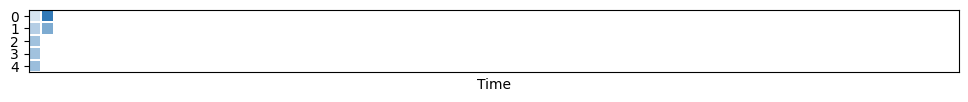

In [21]:
timeseries_heatmap(dataframe=melted_final_df,
                   entity_column="ts_value",
                   )

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

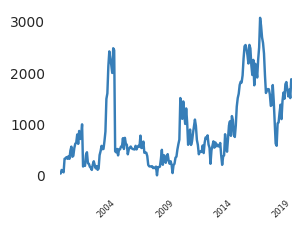

In [27]:
profile = ProfileReport(final_df_wona, minimal=True, tsmode=True)
profile.to_file('profile_report.html')
# profile.to_notebook_iframe()